# Многопоточное программирование - реализация различных алгоритмов

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from matplotlib import cm
import time

### Алгоритм Монте - Карло для оценки числа $\pi$

In [22]:
def one_test(executableName, filename) -> None:
    global path
    global estimations, time 
    result = subprocess.Popen([path+executableName], stdout = subprocess.PIPE)
    stdout, stderr = result.communicate()
    time.append(int(stdout.decode('utf-8').split(' ')[1]))
    estimations.append(np.loadtxt(filename))

In [23]:
path = r'/home/vladimir/BOTAY!/CplusplusHOMEWORK/lesson_2_7/'
executableName_1 = r'pi_one_thread'
exeecutableName_2 = r'mont_8_threads'
estimations = []
time = []
iter_depth = int(1e5)

In [24]:
for _ in range(50):
    one_test(executableName = executableName_1, filename = 'exp_1.txt')

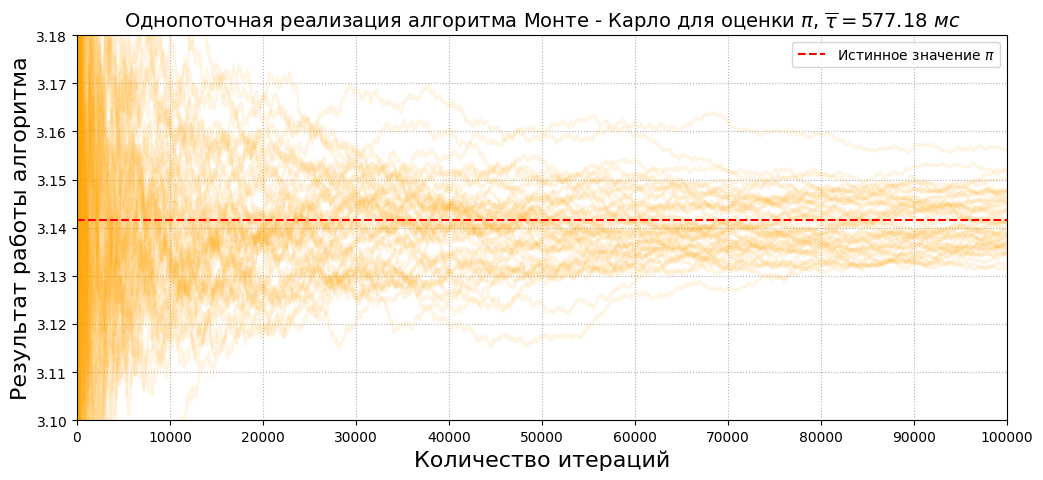

In [25]:
plt.figure(figsize = (12, 5))
sizes = np.arange(iter_depth) + 1

for ind, est in enumerate(estimations):
    plt.plot(sizes, 
             est, 
             alpha = 0.1, 
             color = 'orange')

plt.grid(ls = ':')
plt.ylim(3.1, 3.18)
plt.axhline(np.pi, color = 'red', linestyle = '--', label = r'Истинное значение $\pi$')
plt.xticks(np.arange(0, iter_depth + 1e4, 1e4))
plt.xlim(0, iter_depth)

plt.legend()
plt.xlabel("Количество итераций", fontsize = 16)
plt.ylabel("Результат работы алгоритма", fontsize = 16)
plt.title(r"Однопоточная реализация алгоритма Монте - Карло для оценки $\pi$, $\overline{\tau} = " \
           + str(np.round(np.mean(time), 2)) + "\ мс$", fontsize = 14);

In [26]:
estimations = []
time = []
for _ in range(50):
    one_test(executableName = exeecutableName_2, filename = 'exp_2.txt')

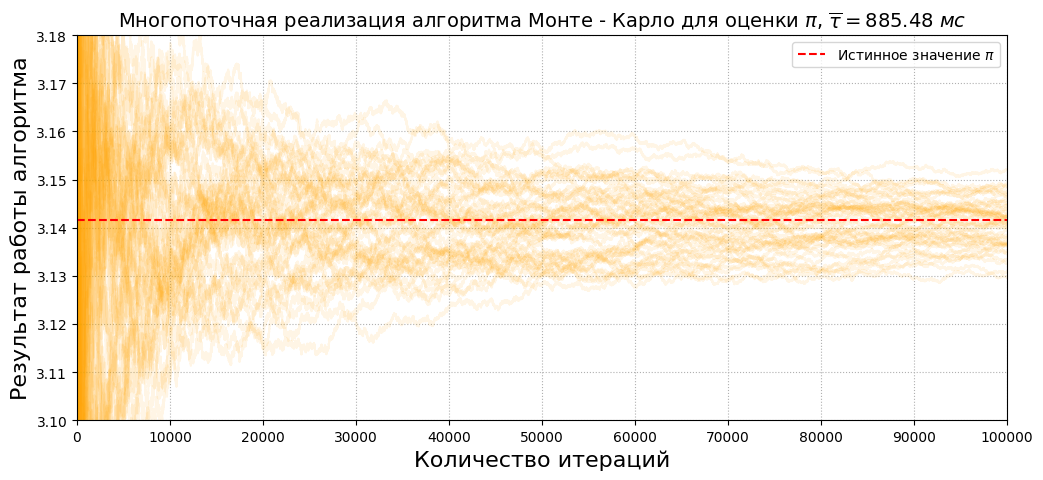

In [27]:
plt.figure(figsize = (12, 5))
sizes = np.arange(iter_depth) + 1

for ind, est in enumerate(estimations):
    plt.plot(sizes, 
             est, 
             alpha = 0.1, 
             color = 'orange')

plt.grid(ls = ':')
plt.ylim(3.1, 3.18)
plt.axhline(np.pi, color = 'red', linestyle = '--', label = r'Истинное значение $\pi$')
plt.xticks(np.arange(0, iter_depth + 1e4, 1e4))
plt.xlim(0, iter_depth)

plt.legend()
plt.xlabel("Количество итераций", fontsize = 16)
plt.ylabel("Результат работы алгоритма", fontsize = 16)
plt.title(r"Многопоточная реализация алгоритма Монте - Карло для оценки $\pi$, $\overline{\tau} = " \
           + str(np.round(np.mean(time), 2)) + "\ мс$", fontsize = 14);

### Многопоточное умножение матриц

In [46]:
path = r'/home/vladimir/BOTAY!/CplusplusHOMEWORK/lesson_2_7/matrix_mult/'
executableName = 'mat'

In [81]:
def execute(a_shape, b_shape, thread_count = 4):
    global path, executableName
    result = subprocess.Popen([path+executableName, str(a_shape[0]), str(a_shape[1]), str(b_shape[0]), str(b_shape[1]), str(thread_count)], stdout = subprocess.PIPE)
    stdout, stderr = result.communicate()
    return int(stdout.decode('utf-8').split(' ')[1])

In [72]:
def check_truth():
    a = np.loadtxt("A.txt").astype(np.int64)
    b = np.loadtxt("B.txt").astype(np.int64)
    c = np.loadtxt("C.txt").astype(np.int64)
    return np.allclose(a @ b, c)

In [147]:
a_shape, b_shape = (500, 500), (500, 500)
execute(a_shape, b_shape)

235

In [148]:
check_truth()

True

In [87]:
mat_mul_test_str = 'c_numpy = a @ b'
c_numpy = 0

In [157]:
size_values = np.arange(100, 1000, 50)
thread_num_values = np.arange(15) + 1
time_different_threads_num = {th: [] for th in thread_num_values}
time_different_threads_num['numpy'] = []
for thread_num in thread_num_values:
    for size in size_values:
        time_different_threads_num[thread_num].append(execute((size, size), (size, size), thread_num))
        a = np.loadtxt("A.txt")
        b = np.loadtxt("B.txt")
        c = np.loadtxt("C.txt")
        if thread_num == 8:
            time_point = time.time()
            c_numpy = a @ b
            time_different_threads_num["numpy"].append(time.time() - time_point)
        c_numpy = a @ b
        assert(np.allclose(c, c_numpy))

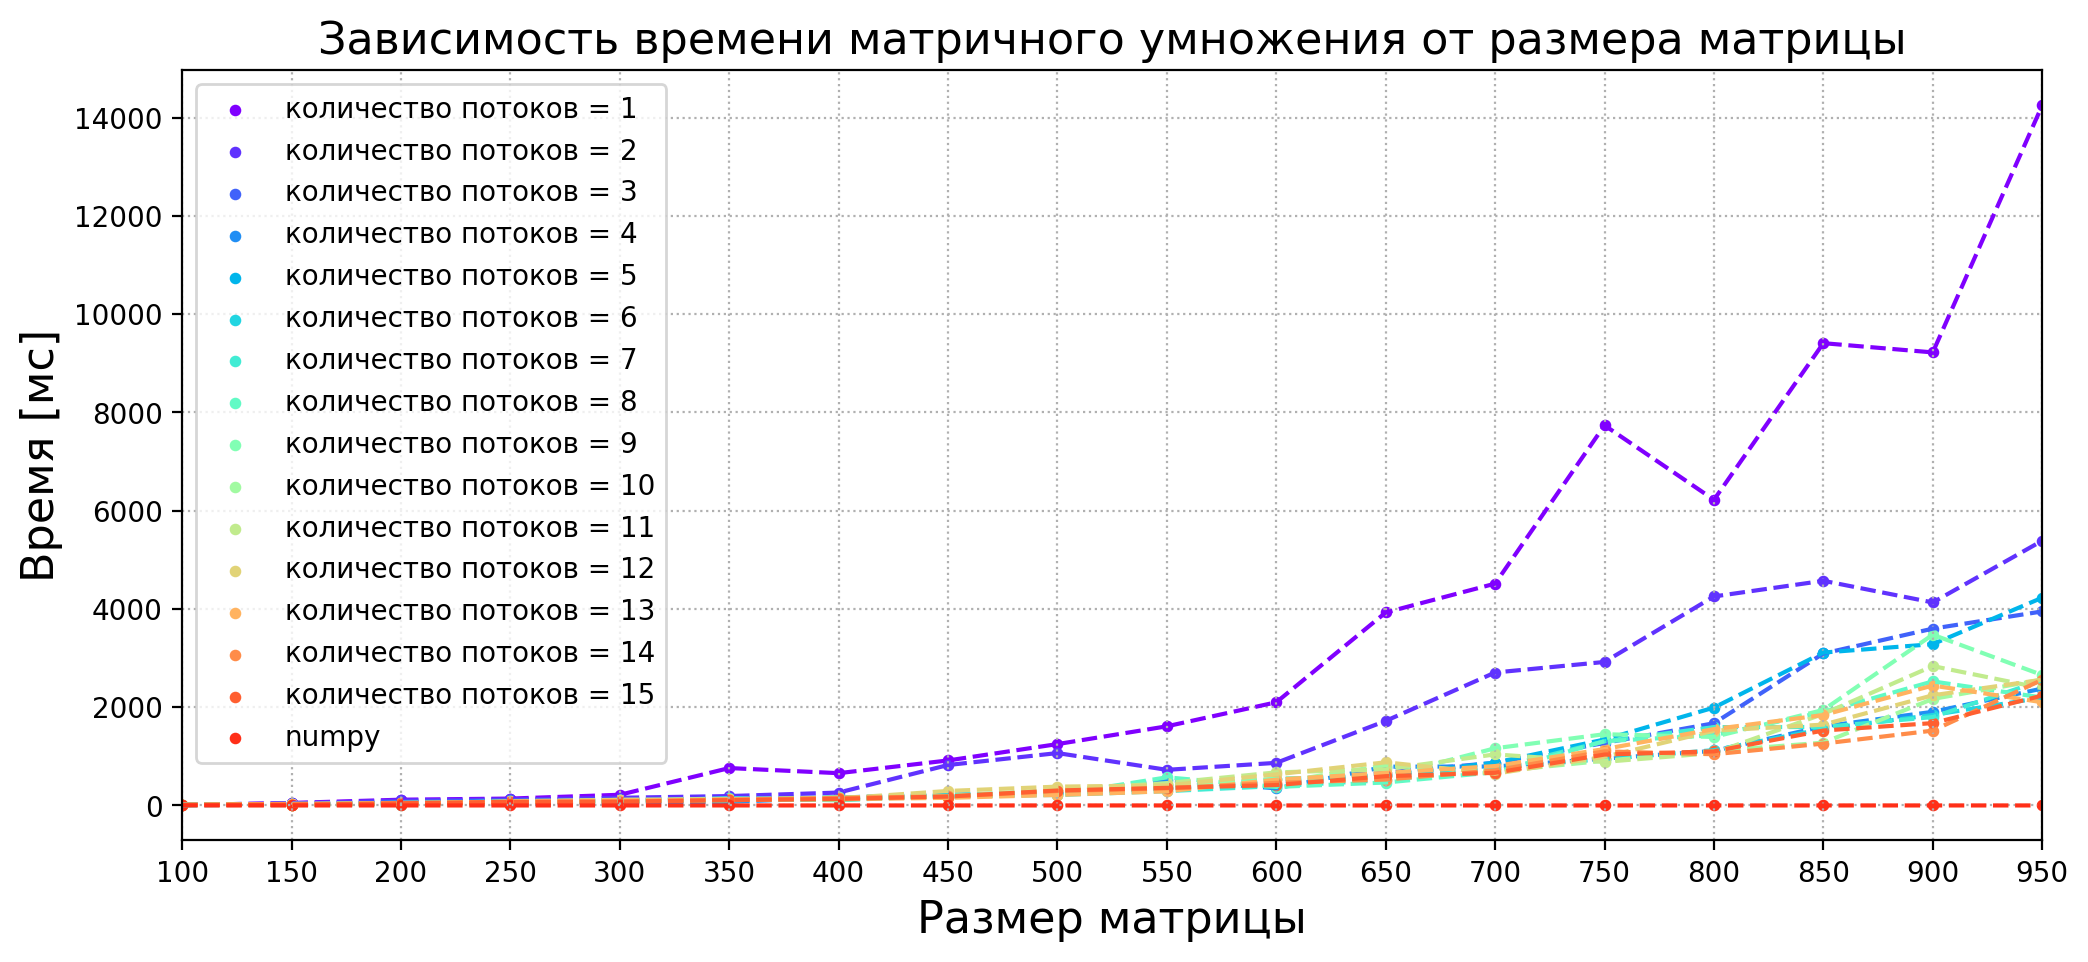

In [158]:
plt.figure(figsize = (12, 5), dpi = 200)

for ind, (name, data) in enumerate(time_different_threads_num.items()):
    label = str(name)
    if name != 'numpy':
        label = f'количество потоков = {name}'
    
    plt.plot(size_values, 
             data,  
             color = cm.rainbow(ind / len(time_different_threads_num)),
             linestyle = '--')
    plt.scatter(size_values, 
                data, 
                label = label, 
                color = cm.rainbow(ind / len(time_different_threads_num)),
                s = 10)

plt.legend()
plt.title("Зависимость времени матричного умножения от размера матрицы", fontsize = 16)
plt.ylabel("Время [мс]", fontsize = 16)
plt.xlabel("Размер матрицы", fontsize = 16)
plt.xticks(np.arange(100, 1000, 50))
plt.xlim(100, 950)
plt.grid(ls = ':');